## <center>Bayesian Optimization <center>
Bayesian Optimization is an approach that uses Bayes Theorem to direct the search in order to find the minimum or maximum of an objective function. It is an approach that is most useful for objective functions that are complex, noisy, and/or expensive to evaluate. 

Recall that Bayes Theorem is an approach for calculating the conditional probability of an event:

$$P(A|B) = P(B|A) * P(A) / P(B)$$
We can simplify this calculation by removing the normalizing value of $P(B)$ and describe the conditional probability as a proportional quantity. This is useful as we are not interested in calculating a specific conditional probability, but instead in optimizing a quantity.

$$P(A|B) = P(B|A) * P(A)$$
The conditional probability that we are calculating is referred to generally as the posterior probability; the reverse conditional probability is sometimes referred to as the likelihood, and the marginal probability is referred to as the prior probability; for example:

$$posterior = likelihood * prior$$
This provides a framework that can be used to quantify the beliefs about an unknown objective function given samples from the domain and their evaluation via the objective function.

We can devise specific samples ($x_1$, $x_2$, …, $x_n$) and evaluate them using the objective function $f(x_i)$ that returns the cost or outcome for the sample $x_i$. Samples and their outcome are collected sequentially and define our data $D$, e.g. $D = {x_i, f(x_i), … x_n, f(x_n)}$ and is used to define the prior. 

The likelihood function is defined as the probability of observing the data given the function $P(D | f)$. This likelihood function will change as more observations are collected.

$$P(f|D) = P(D|f) * P(f)$$
The posterior represents everything we know about the objective function. It is an approximation of the objective function and can be used to estimate the cost of different candidate samples that we may want to evaluate. In this way, the posterior probability is a *surrogate* objective function. The posterior captures the updated beliefs about the unknown objective function. One may also interpret this step of Bayesian optimization as estimating the objective function with a surrogate function (also called a response surface).

**Surrogate Function:** Bayesian approximation of the objective function that can be sampled efficiently.
The surrogate function gives us an estimate of the objective function, which can be used to direct future sampling. Sampling involves careful use of the posterior in a function known as the “acquisition” function, e.g. for acquiring more samples. We want to use our belief about the objective function to sample the area of the search space that is most likely to pay off, therefore the acquisition will optimize the conditional probability of locations in the search to generate the next sample.

**Acquisition Function:** Technique by which the posterior is used to select the next sample from the search space.
Once additional samples and their evaluation via the objective function f() have been collected, they are added to data D and the posterior is then updated.

This process is repeated until the extrema of the objective function is located, a good enough result is located, or resources are exhausted.

The Bayesian Optimization algorithm can be summarized as follows:

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.



For more theory visit: https://machinelearningmastery.com/what-is-bayesian-optimization/

### Test problem
We will use a multimodal problem with five peaks, calculated as:

$$y = x^2 * sin(5\pi x)^6$$

We will augment this function by adding Gaussian noise with a mean of zero and a standard deviation of 0.1. This will mean that the real evaluation will have a positive or negative random value added to it, making the function challenging to optimize

Optima: x=0.900, y=0.810


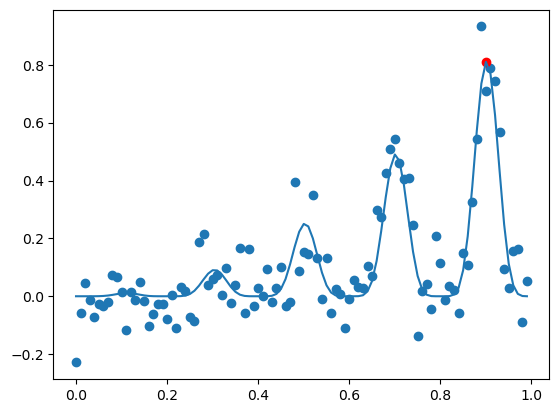

In [1]:
# Example problem
import numpy as np 
import matplotlib.pyplot as plt

# objective function
def objective(x, noise=0.1):
    noise = np.random.normal(loc=0, scale=noise)
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise
 
# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
idx = np.argmax(y)
X_opt, y_opt = X[idx], y[idx]
print('Optima: x=%.3f, y=%.3f' % (X_opt, y_opt))
# plot the points with noise
plt.scatter(X, ynoise)
# plot the points without noise
plt.plot(X, y)
# plot optima
plt.scatter(X_opt, y_opt, color="red");

### Surrogate Function
The surrogate function is a technique used to best approximate the mapping of input examples to an output score. Probabilistically, it summarizes the conditional probability of an objective function (f), given the available data (D) or P(f|D).

A number of techniques can be used for this, although the most popular is to treat the problem as a regression predictive modeling problem with the data representing the input and the score representing the output to the model. This is often best modeled using a random forest or a Gaussian Process. A Gaussian Process, or GP, is a model that constructs a joint probability distribution over the variables, assuming a multivariate Gaussian distribution. As such, it is capable of efficient and effective summarization of a large number of functions and smooth transition as more observations are made available to the model.

This smooth structure and smooth transition to new functions based on data are desirable properties as we sample the domain, and the multivariate Gaussian basis to the model means that an estimate from the model will be a mean of a distribution with a standard deviation; that will be helpful later in the acquisition function. As such, using a GP regression model is often preferred.

We can fit a GP regression model using the GaussianProcessRegressor scikit-learn implementation from a sample of inputs (X) and noisy evaluations from the objective function (y).

First, the model must be defined. An important aspect in defining the GP model is the kernel. This controls the shape of the function at specific points based on distance measures between actual data observations. Many different kernel functions can be used, and some may offer better performance for specific datasets. By default, a Radial Basis Function, or RBF, is used that can work well.

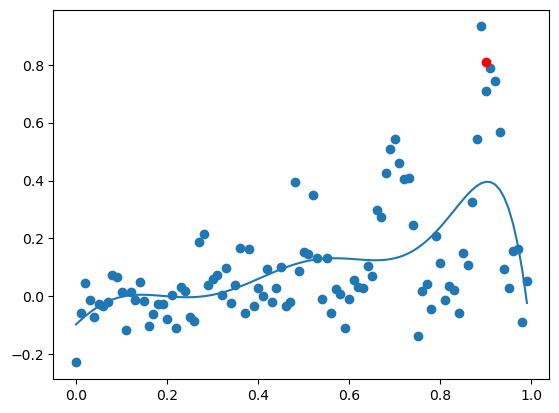

In [2]:
# Surrogate function
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

def surrogate(X, y):
    model = GaussianProcessRegressor()
    X = X.reshape(-1, 1)
    model.fit(X, y)
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
    
    return model.predict(X, return_std=True)


y_hat, _ = surrogate(X, ynoise)


# plot the points with noise
plt.scatter(X, ynoise)
# plot the points without noise
plt.plot(X, y_hat)
# plot optima
plt.scatter(X[idx], y[idx], color="red");

### Acquisition Function
The surrogate function is used to test a range of candidate samples in the domain. From these results, one or more candidates can be selected and evaluated with the real, and in normal practice, computationally expensive cost function.This involves two pieces: the search strategy used to navigate the domain in response to the surrogate function and the acquisition function that is used to interpret and score the response from the surrogate function.

A simple search strategy, such as a random sample or grid-based sample, can be used, although it is more common to use a local search strategy, such as the popular BFGS algorithm. In this case, we will use a random search or random sample of the domain in order to keep the example simple. This involves first drawing a random sample of candidate samples from the domain, evaluating them with the acquisition function, then maximizing the acquisition function or choosing the candidate sample that gives the best score. The opt_acquisition() function below implements this.


The acquisition function is responsible for scoring or estimating the likelihood that a given candidate sample (input) is worth evaluating with the real objective function. We could just use the surrogate score directly. Alternately, given that we have chosen a Gaussian Process model as the surrogate function, we can use the probabilistic information from this model in the acquisition function to calculate the probability that a given sample is worth evaluating.

There are many different types of probabilistic acquisition functions that can be used, each providing a different trade-off for how exploitative (greedy) and explorative they are.

Three common examples include:

- Probability of Improvement (PI).
- Expected Improvement (EI).
- Lower Confidence Bound (LCB).


The Probability of Improvement method is the simplest, whereas the Expected Improvement method is the most commonly used.In this case, we will use the simpler Probability of Improvement method, which is calculated as the normal cumulative probability of the normalized expected improvement, calculated as follows:

$$PI = cdf((mu – best_mu) / stdev)$$
Where PI is the probability of improvement, cdf() is the normal cumulative distribution function, mu is the mean of the surrogate function for a given sample x, stdev is the standard deviation of the surrogate function for a given sample x, and best_mu is the mean of the surrogate function for the best sample found so far.

We can add a very small number to the standard deviation to avoid a divide by zero error.

The acquisition() function below implements this given the current training dataset of input samples, an array of new candidate samples, and the fit GP model.

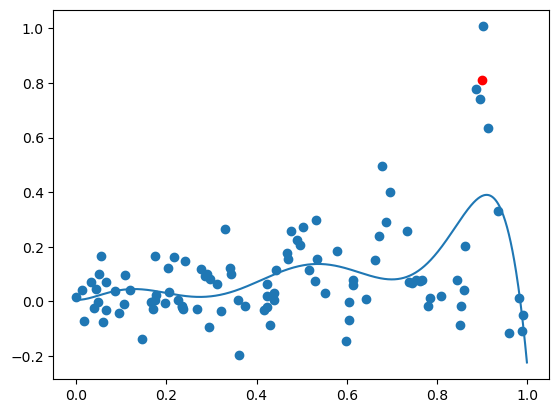

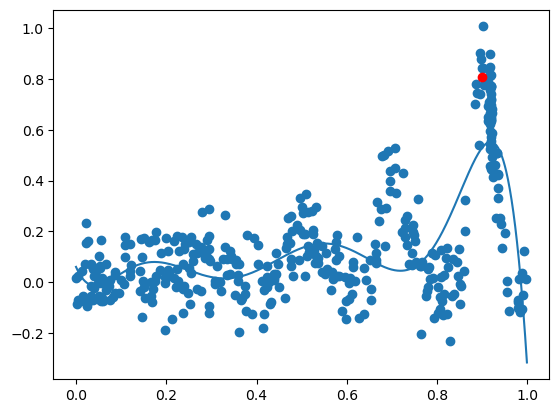

Best Result: ([0.90105901], [1.00708362])
Optima point: (0.9, 0.81)


In [3]:
# Full code for Bayesian optimization (BO)
import numpy as np 
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy.random import normal, random
from scipy.stats import norm


# objective function
def objective(x, noise=0.1):
    noise = normal(loc=0, scale=noise)
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + noise


# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():  
        # ignore generated warnings
        simplefilter("ignore")
    return model.predict(X, return_std=True)
 

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
 
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs
 

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(-1, 1)
 
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
 
    # locate the index of the largest scores
    idx = np.argmax(scores)
    return Xsamples[idx, 0]


def plot(X, y, model):
    # scatter plot of inputs and real objective function
    plt.scatter(X, y)
    
    # line plot of surrogate function across domain
    Xsamples = np.arange(0, 1, 0.001).reshape(-1, 1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples)
    plt.scatter(X_opt, y_opt, color="red")
    
    # show the plot
    plt.show()
    
 

# sample the domain sparsely with noise
X = random(100).reshape(-1, 1)
y = np.array([objective(x) for x in X])

# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)

# plot before hand
plot(X, y, model)


# perform the optimization process
for i in range(300):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    #print(f"x: {x}, f(x): {est.item()}, actual: {actual}")
    
    # add the data to the dataset
    X = np.vstack((X, [[x]]))
    y = np.vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)


# plot all samples and the final surrogate function
plot(X, y, model)
# best result
idx = np.argmax(y)
print(f"Best Result: ({X[idx]}, {y[idx]})")
print(f"Optima point: ({X_opt}, {y_opt})")